In [13]:
import pandas as pd
import numpy as np
import yfinance as yf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from datetime import datetime

import shap


def analyze_issues(data, target_col, model):
    """
    Detects overfitting, multicollinearity, low variance features, and other issues using SHAP.
    Args:
        data (DataFrame): Dataset containing features and target column.
        target_col (str): The name of the target column.
        model: XGBoost model to evaluate.
    """
    issues = []

    # Step 1: Split data into features (X) and target (y)
    X = data.drop(columns=[target_col])
    y = data[target_col]

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Step 2: Train the model
    model.fit(X_train, y_train)
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    # Step 3: Check for overfitting
    train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
    test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
    print(f"Train RMSE: {train_rmse}")
    print(f"Test RMSE: {test_rmse}")

    if train_rmse < test_rmse and (test_rmse - train_rmse) / train_rmse > 0.2:
        issues.append("Overfitting detected: Train RMSE is much lower than Test RMSE.")

    # Step 4: Check for multicollinearity
    X_vif = add_constant(X)  # Add constant for intercept
    vif = pd.DataFrame()
    vif["Feature"] = X_vif.columns
    vif["VIF"] = [
        variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])
    ]
    print("\nVIF Results:")
    print(vif)

    if vif["VIF"].max() > 10:
        issues.append("Multicollinearity detected: High VIF values.")

    # Step 5: Check feature correlation
    corr_matrix = X.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=False, cmap="coolwarm")
    plt.title("Feature Correlation Matrix")
    plt.show()

    if (corr_matrix.abs() > 0.8).sum().sum() > len(
        corr_matrix
    ):  # Exclude diagonal 1.0 correlations
        issues.append("High correlation detected between features.")

    # Step 6: Check for low variance features
    low_variance_features = X.columns[X.var() < 0.01]
    if not low_variance_features.empty:
        issues.append(f"Low variance features detected: {list(low_variance_features)}")

    # Step 7: SHAP analysis for feature importance
    explainer = shap.Explainer(model)
    shap_values = explainer(X)
    print("\nSHAP Summary Plot:")
    shap.summary_plot(shap_values, X)

    # Step 8: Print results
    if not issues:
        print("\nNo significant issues detected.")
    else:
        print("\nIssues detected:")
        for issue in issues:
            print(f"- {issue}")


# Load dataset
file_path = "C:/Users/aqeel/work/NEU/DS INFO6105/final_dashboard/data/3.csv"  # Replace with your file path
data = pd.read_csv(file_path)

# Download Meta stock data and calculate log returns
meta_data = yf.download("META", start="2020-01-01", end="2024-08-30", interval="1d")
meta_data["Log Return"] = np.log(meta_data["Close"] / meta_data["Close"].shift(1))
meta_data = meta_data.dropna()
meta_data.reset_index(inplace=True)

# Convert 'Date' column to datetime and merge datasets
data["Date"] = pd.to_datetime(data["Date"])
meta_data["Date"] = pd.to_datetime(meta_data["Date"])
meta_data.columns = [
    col[0] if col[1] == "" else f"{col[0]}_{col[1]}" for col in meta_data.columns
]

merged_data = pd.merge(data, meta_data[["Date", "Log Return"]], on="Date", how="inner")

# Analyze issues using XGBoost and SHAP
xgb_model = XGBRegressor(
    learning_rate=0.1, max_depth=3, n_estimators=100, random_state=42
)
analyze_issues(merged_data, "Log Return", xgb_model)


[*********************100%***********************]  1 of 1 completed


ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:Date: datetime64[ns]

[*********************100%***********************]  1 of 1 completed


Train RMSE: 0.0006960321740984827
Test RMSE: 0.013470705166608508

VIF Results:
                 Feature           VIF
0                  const  16546.200731
1                 Mkt-RF      2.087941
2                    SMB      1.621767
3                    HML      2.489197
4                    RMW      1.625024
5                    CMA      1.996956
6                     RF    115.690386
7              ADS_Index      2.976856
8                  SP500     47.128804
9                 T10Y3M    205.559144
10                 DGS10    561.093343
11        OBMMIJUMBO30YF    107.032835
12               DEXUSEU     28.438788
13               DEXJPUS     86.201650
14               DEXUSUK     27.057343
15              CBBTCUSD     16.212006
16              CBETHUSD     17.474599
17                T10YIE    172.971298
18          DCOILBRENTEU     30.859533
19                VIXCLS      9.484469
20                  DAAA    444.362206
21                  DBAA    496.253047
22              AMERIBO

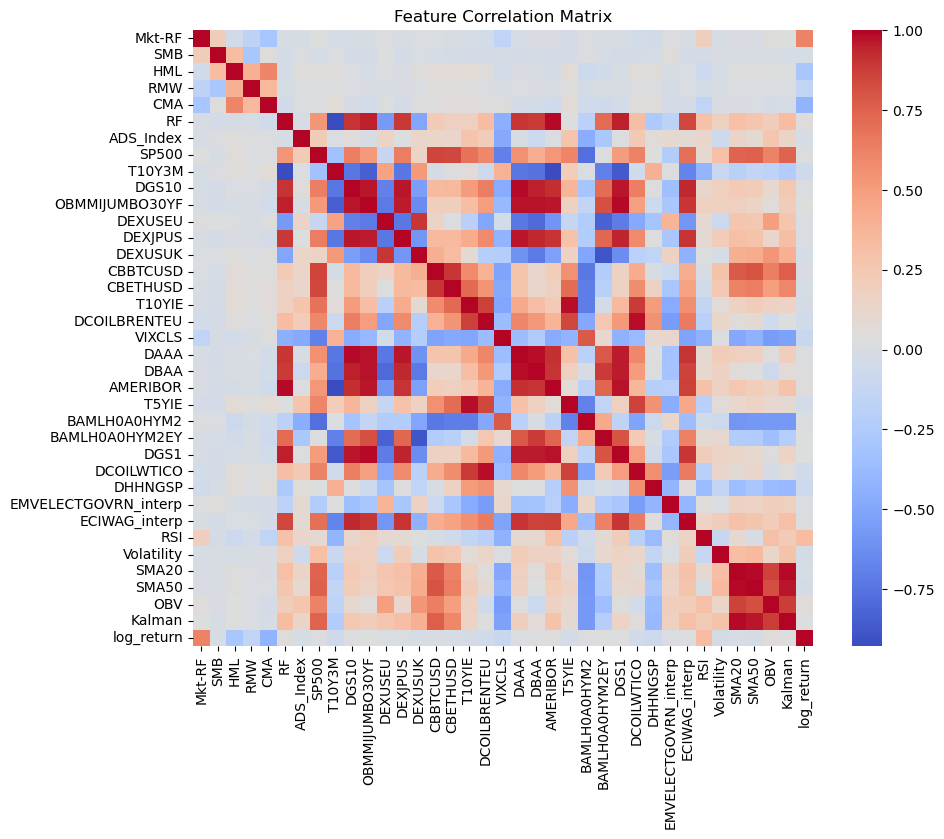


SHAP Summary Plot:


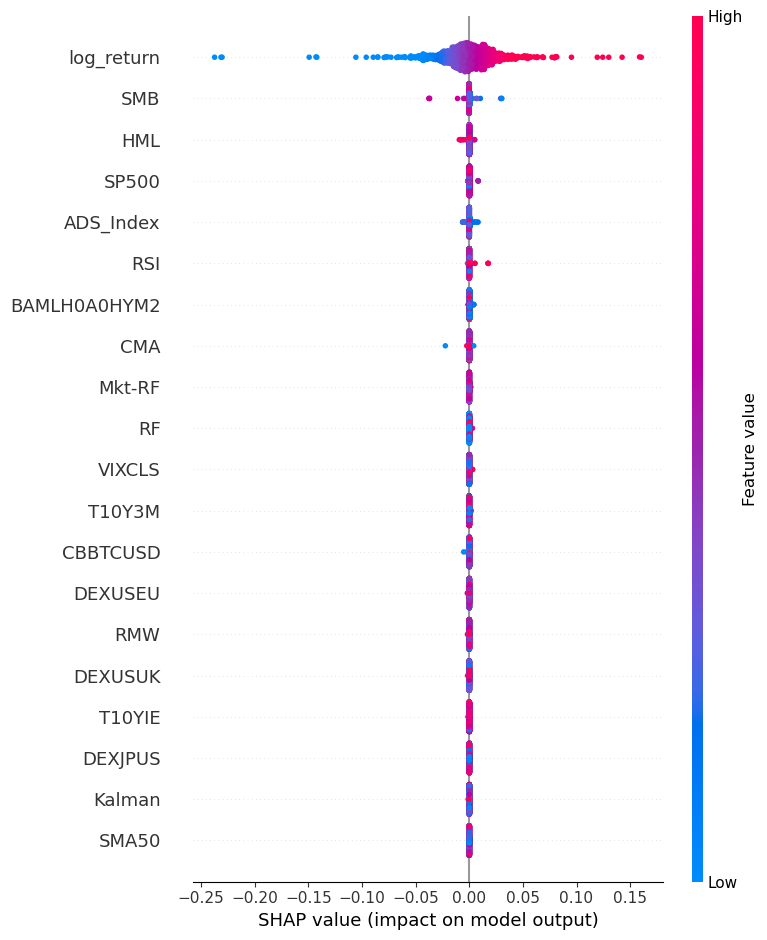


Issues detected:
- Overfitting detected: Train RMSE is much lower than Test RMSE.
- High correlation detected between features.
- Low variance features detected: ['RF', 'DEXUSEU', 'DEXUSUK', 'log_return']


In [16]:
def analyze_issues(data, target_col, model):
    """
    Detects overfitting, multicollinearity, low variance features, and other issues using SHAP.
    """
    issues = []

    # Step 1: Prepare features, removing date and non-numeric columns
    X = data.drop(columns=[target_col, "Date"])
    X = X.select_dtypes(include=["int64", "float64"])

    # Handle missing values and infinities
    X = X.replace([np.inf, -np.inf], np.nan)  # Replace infinities with NaN
    X = X.fillna(X.mean())  # Fill NaN with mean values
    y = data[target_col]

    # print("Features used:", X.columns.tolist())
    # print("Feature types:\n", X.dtypes)
    # print("Missing values:\n", X.isnull().sum())

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Train model
    model.fit(X_train, y_train)
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    # Calculate RMSE
    train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
    test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
    print(f"Train RMSE: {train_rmse}")
    print(f"Test RMSE: {test_rmse}")

    if train_rmse < test_rmse and (test_rmse - train_rmse) / train_rmse > 0.2:
        issues.append("Overfitting detected: Train RMSE is much lower than Test RMSE.")

    # Calculate VIF with cleaned data
    X_vif = add_constant(X)
    vif = pd.DataFrame()
    vif["Feature"] = X_vif.columns
    vif["VIF"] = [
        variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])
    ]
    print("\nVIF Results:")
    print(vif)

    # Correlation analysis
    corr_matrix = X.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=False, cmap="coolwarm")
    plt.title("Feature Correlation Matrix")
    plt.show()

    if (corr_matrix.abs() > 0.8).sum().sum() > len(corr_matrix):
        issues.append("High correlation detected between features.")

    # Check variance
    low_variance_features = X.columns[X.var() < 0.01]
    if len(low_variance_features) > 0:
        issues.append(f"Low variance features detected: {list(low_variance_features)}")

    # SHAP analysis
    explainer = shap.Explainer(model)
    shap_values = explainer(X)
    print("\nSHAP Summary Plot:")
    shap.summary_plot(shap_values, X)

    if not issues:
        print("\nNo significant issues detected.")
    else:
        print("\nIssues detected:")
        for issue in issues:
            print(f"- {issue}")


# Load and prepare data
file_path = "C:/Users/aqeel/work/NEU/DS INFO6105/final_dashboard/data/3.csv"
data = pd.read_csv(file_path)

# Download Meta stock data
meta_data = yf.download("META", start="2020-01-01", end="2024-08-30", interval="1d")
meta_data["Log Return"] = np.log(meta_data["Close"] / meta_data["Close"].shift(1))
meta_data = meta_data.dropna()
meta_data.reset_index(inplace=True)

# Prepare dates and merge
data["Date"] = pd.to_datetime(data["Date"])
meta_data["Date"] = pd.to_datetime(meta_data["Date"])
meta_data.columns = [
    col[0] if isinstance(col, tuple) and col[1] == "" else f"{col[0]}_{col[1]}"
    for col in meta_data.columns
]

# Merge and handle missing values
merged_data = pd.merge(data, meta_data[["Date", "Log Return"]], on="Date", how="inner")
merged_data = merged_data.replace([np.inf, -np.inf], np.nan)
merged_data = merged_data.fillna(merged_data.mean())

# Run analysis
xgb_model = XGBRegressor(
    learning_rate=0.1, max_depth=3, n_estimators=100, random_state=42
)
analyze_issues(merged_data, "Log Return", xgb_model)


[*********************100%***********************]  1 of 1 completed

Train RMSE with tuned hyperparameters: 0.012511472581795167
Test RMSE with tuned hyperparameters: 0.026237715508375697


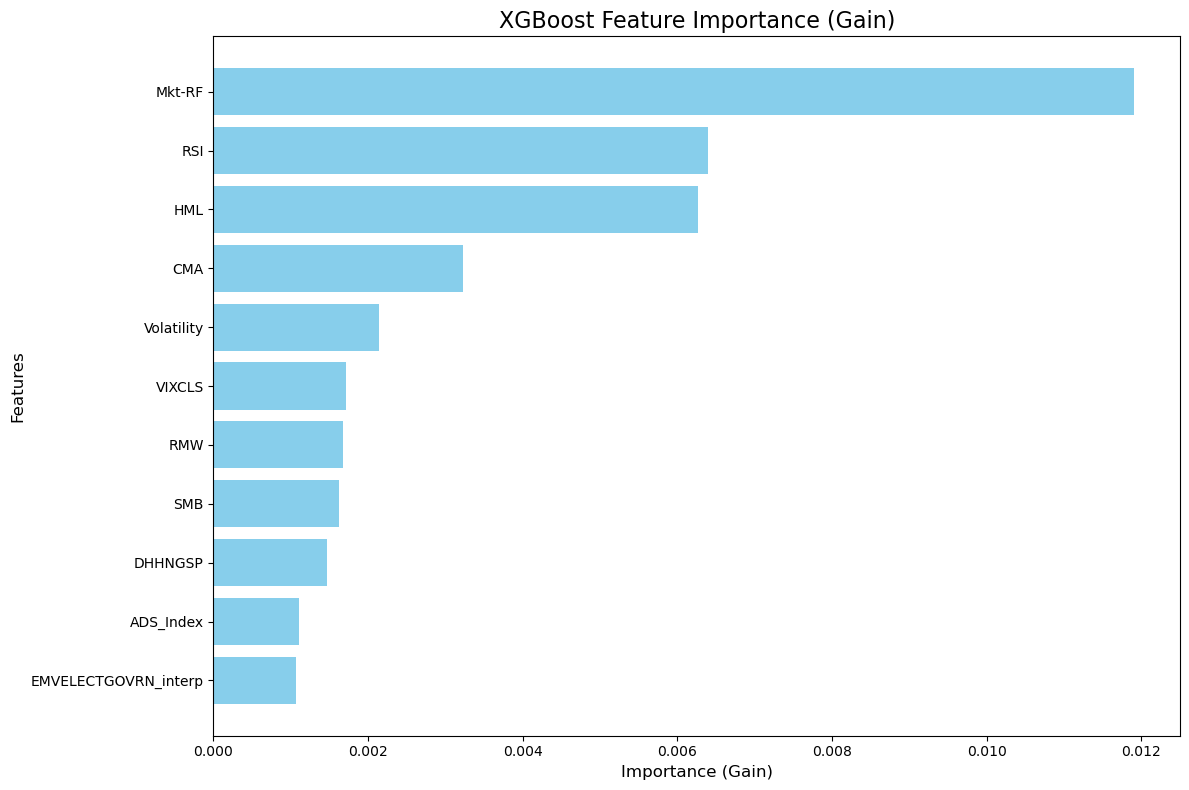

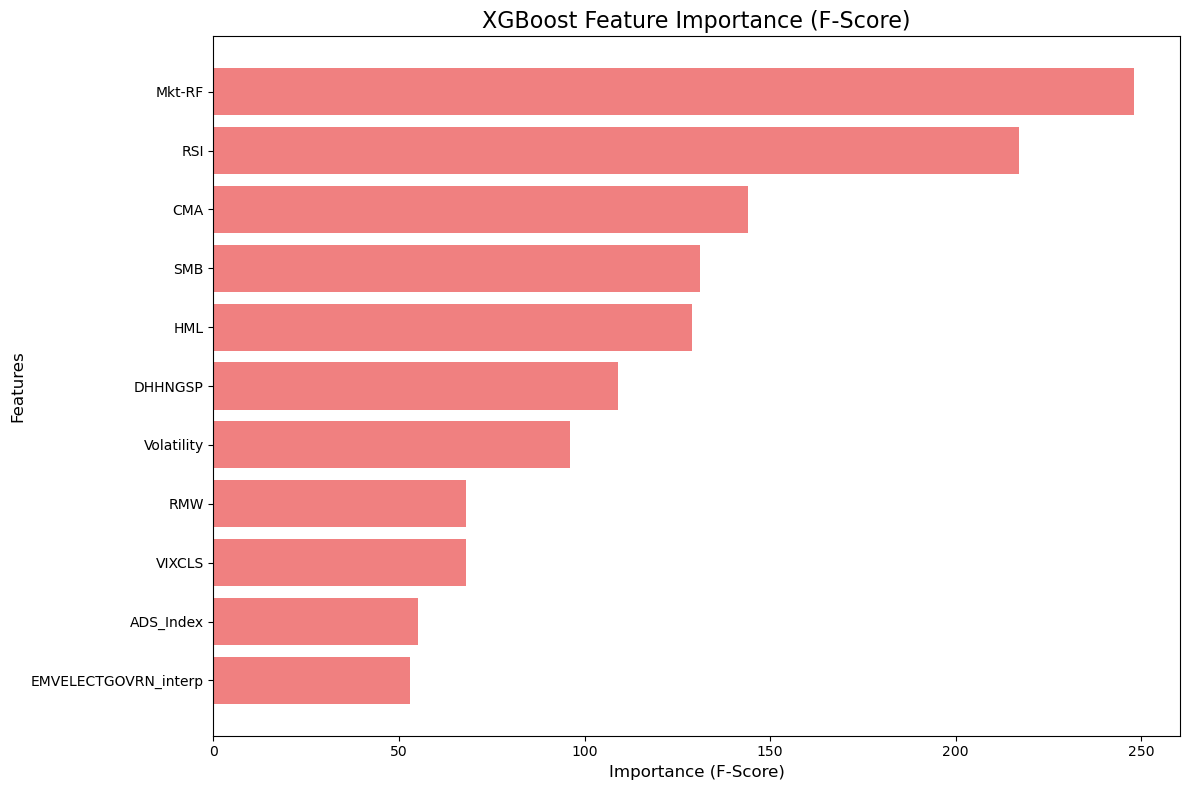

In [11]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import xgboost as xgb
import matplotlib.pyplot as plt

# Step 1: Download Meta stock data for the specified time frame
meta_data = yf.download("META", start="2020-01-01", end="2024-08-30", interval="1d")

# Reset index to make 'Date' a column
meta_data.reset_index(inplace=True)

# Calculate log returns for Meta stock
meta_data["Log Return"] = np.log(meta_data["Close"] / meta_data["Close"].shift(1))
meta_data = (
    meta_data.dropna()
)  # Drop rows with NaN values caused by the shift operation

# Keep only relevant columns: Date and Log Return
meta_data = meta_data[["Date", "Log Return"]]

# Step 2: Load the provided dataset (3.csv)
file_path = "C:/Users/aqeel/work/NEU/DS INFO6105/final_dashboard/data/3.csv"  # Update if necessary
data = pd.read_csv(file_path)

# Convert the 'Date' column to datetime for both datasets
data["Date"] = pd.to_datetime(data["Date"])
meta_data["Date"] = pd.to_datetime(meta_data["Date"])

# Drop 'log_return' column from 3.csv if it exists
if "log_return" in data.columns:
    data = data.drop(columns=["log_return"])


# Flatten the multi-level columns in meta_data
meta_data.columns = [
    col[0] if col[1] == "" else f"{col[0]}_{col[1]}" for col in meta_data.columns
]


# Step 3: Align datasets by date using an inner join
merged_data = pd.merge(data, meta_data, on="Date", how="inner")

# Handle missing values in features by imputing with the mean
merged_data.fillna(merged_data.mean(), inplace=True)

# Step 4: Define features (X) and target (y)
X = merged_data.drop(columns=["Date", "Log Return"])  # Drop irrelevant columns
y = merged_data["Log Return"]

# Step 5: Eliminate problematic features
# 5.1 Remove features with high VIF
X_vif = add_constant(X)  # Add constant for intercept
vif = pd.DataFrame()
vif["Feature"] = X_vif.columns
vif["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
high_vif_features = vif[vif["VIF"] > 10]["Feature"].tolist()
X = X.drop(columns=high_vif_features, errors="ignore")

# 5.2 Remove low variance features
low_variance_features = X.columns[X.var() < 0.01].tolist()
X = X.drop(columns=low_variance_features, errors="ignore")

# 5.3 Remove highly correlated features
correlation_threshold = 0.8
corr_matrix = X.corr().abs()
upper_triangle = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)
high_corr_features = [
    column
    for column in upper_triangle.columns
    if any(upper_triangle[column] > correlation_threshold)
]
X = X.drop(columns=high_corr_features, errors="ignore")

# Step 6: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Step 7: Initialize the XGBoost model with tuned hyperparameters
xgb_model = xgb.XGBRegressor(
    learning_rate=0.05, max_depth=3, n_estimators=200, random_state=42
)

# Train the model
xgb_model.fit(X_train, y_train)

# Step 8: Evaluate the model and calculate RMSE
train_preds = xgb_model.predict(X_train)
test_preds = xgb_model.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))

print(f"Train RMSE with tuned hyperparameters: {train_rmse}")
print(f"Test RMSE with tuned hyperparameters: {test_rmse}")

# Extract feature importance
feature_importances_gain = xgb_model.get_booster().get_score(importance_type="gain")
feature_importances_fscore = xgb_model.get_booster().get_score(importance_type="weight")

# Convert importance dictionaries to pandas DataFrame for visualization
gain_importance_df = pd.DataFrame(
    feature_importances_gain.items(), columns=["Feature", "Importance (Gain)"]
).sort_values(by="Importance (Gain)", ascending=False)
fscore_importance_df = pd.DataFrame(
    feature_importances_fscore.items(), columns=["Feature", "Importance (F-Score)"]
).sort_values(by="Importance (F-Score)", ascending=False)

# Step 9: Visualize feature importance (Gain)
plt.figure(figsize=(12, 8))
plt.barh(
    gain_importance_df["Feature"],
    gain_importance_df["Importance (Gain)"],
    color="skyblue",
)
plt.title("XGBoost Feature Importance (Gain)", fontsize=16)
plt.xlabel("Importance (Gain)", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Step 10: Visualize feature importance (F-Score)
plt.figure(figsize=(12, 8))
plt.barh(
    fscore_importance_df["Feature"],
    fscore_importance_df["Importance (F-Score)"],
    color="lightcoral",
)
plt.title("XGBoost Feature Importance (F-Score)", fontsize=16)
plt.xlabel("Importance (F-Score)", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()